# Scientific Abstract Text Generation -- Word Level

In a previous project, I have demonstrated the use of an LSTM network to learn scientific text from PubMed abstracts and generate texts to emulate academic writing [link](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/manuscripts_text_generation.ipynb). The previous project performs **character-level** prediction, which means the network receives a sequence of 100 characters and aims to predict the following *character*. The advantage of this method is that there are only <100 possible alphanumeric characters, so the fully-connected layer at the end performs a classification and chooses the character with the highest softmax likelihood. The disadvantage is that without a large training set, the network will generate gibberish characters that do not form coherent words.

In this current work, I will be implementing **word-level** text generation, which means the LSTM network predicts which *word* follows a sequence of 100 words. The advantage of this network is that each word is a correct English word. However, the disadvantage is that there are so many possible words to choose from for the classification fully-connected layer, which means that it is difficult to generate a coherent phrase as well. One notable feature of this LSTM network will be an added **attention** mechanism, which is simply a vector of length 100 (same length as our sequence), that we will use to perform a dot product with the LSTM output sequence before performing the prediction.

To correct for this, I will be implement **beam search**, which is a recursive NLP algorithm; instead of greedily choosing the next word, beam search keeps track of the softmax score for the last *k* steps and chooses the k-length sequence that has the highest score. Usually `k` ranges between 5 and 10, but in this work I will use `k=3` due to limited time and resources.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn import model_selection
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM, SimpleRNN
from tensorflow.keras.layers import Attention, Multiply, LayerNormalization, TimeDistributed
from tensorflow.keras.layers import Activation, Permute, Lambda, RepeatVector
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Data scraped from [PubMed](https://pubmed.ncbi.nlm.nih.gov/) is in this [file](https://github.com/chauvu/chauvu.github.io/blob/main/Data/pubmed/abstracts_str.txt). Let's read in this data and perform some basic cleaning. Ideally, I would have performed lemmatization using NLP libraries such as NLTK or SpaCy, but this step was skipped in this project.

I will create 100-word long sequences and train my LSTM network on them.

In [2]:
filename = "abstracts_str.txt"
abstract_file = open(filename, 'r', encoding='utf-8')
abstract_txt = abstract_file.read()
abstract_txt = abstract_txt.lower()
abstract_file.close()

In [3]:
# split into word-level tokens
abstract_txt = re.sub(r'[^a-zA-Z0-9_\s]', ' ', abstract_txt) # clean text
abstract_txt = abstract_txt.replace('\n', ' \n ')
abstract_wordvec = abstract_txt.split(' ')
abstract_wordvec = [w for w in abstract_wordvec if len(w)>0] # delete empty

# remove out-of-vocab words (< 10 occurences)
word_count = {}
unique_words = sorted(set(abstract_wordvec))
for word in unique_words:
	word_count[word] = abstract_wordvec.count(word)
word_to_remove = [w for w in word_count if word_count[w]<10]
for w in word_to_remove: # delete word
	abstract_txt = abstract_txt.replace(' '+w+' ', ' ')
abstract_wordvec = abstract_txt.split(' ')
abstract_wordvec = [w for w in abstract_wordvec if len(w)>0] # delete empty

In [4]:
seq_len = 100
sequences = []
pred_words = []

for i in range(0, len(abstract_wordvec)-seq_len):
	sequence = abstract_wordvec[i:i+seq_len]
	pred_word = abstract_wordvec[i+seq_len]
	if('\n' not in sequence and '\n'!=pred_word):
		sequences.append(sequence)
		pred_words.append(pred_word)

Let's now tokenize the 100-word sequences. Each word will be represented as a specific integer value. I will also create dictionaries `word2index_dict` and `index2word_dict` to easily convert between natural language words and their index values.

In [5]:
# tokenize
word_list = sorted(set(abstract_wordvec)) # unique words
word_list = word_list[1:] # remove \n newline
index_list = np.arange(len(word_list))
word2index_dict = dict(zip(word_list,index_list))
index2word_dict = dict(zip(index_list,word_list))

sequences_word_list = [] # list of integer arrays
pred_word_list = [] # list of integers
for i in range(0,len(sequences)):
	seq = sequences[i]
	pred_word = pred_words[i]
	seq_word = [word2index_dict[word] for word in list(seq)]
	sequences_word_list.append(seq_word)
	pred_word_list.append(word2index_dict[pred_word])

sequences_word_array = np.array(sequences_word_list)
sequences_word_array = np.reshape(sequences_word_array, (len(sequences_word_array),seq_len,1)) # X
pred_word_list_onehot = tf.keras.utils.to_categorical(np.array(pred_word_list)) # y

# normalize X
sequences_word_array_norm = sequences_word_array / (len(word_list))

To simplify the process of converting a whole sequence of words to indices, and vice versa, I will now create two functions `convert_index_to_wordseq` and `convert_word_to_indexseq`. These functions will be used throughout this project when training and performing predictions.

In [6]:
def convert_index_to_wordseq(index_list): # pass in list of integers
	wordseq = [index2word_dict[index] for index in index_list]
	return wordseq

def convert_word_to_indexseq(word_list): # pass in list of chars
	indexseq = [word2index_dict[word] for word in word_list]
	return indexseq

Here is a test 100-word sentence that I will be using to test the LSTM network.

In [7]:
sentence = 'Few epidemiologic studies have examined the role of maternal iron status in allergic ' \
'diseases in offspring and findings have been inconsistent. We used a large birth cohort in Japan ' \
'to explore the association of the markers for maternal iron status (maternal hemoglobin, hematocrit ' \
'and dietary iron intake during pregnancy) with allergy development in offspring during early ' \
'childhood. We analyzed information on children age 0–3 years from the Japan Environment and ' \
'Children’s Study (JECS). We used logistic models and generalized estimating equation models to ' \
'evaluate the effect of maternal hemoglobin and hematocrit levels and dietary iron intake on ' \
'allergies in children. Models were also fitted with propensity score-matched datasets. Data were ' \
'collected for a total of 91,247 mother–child pairs. The prevalence (95 confidence interval) of ' \
'low hemoglobin and hematocrit was 14.0% (13.7–14.2%) and 12.5% (12.3–12.8%), respectively. After ' \
'adjusting confounders, low hemoglobin and hematocrit during pregnancy were not associated with ' \
'childhood allergic outcomes. Findings from models with propensity score-matched datasets also ' \
'indicated that children born to mothers with low hemoglobin or hematocrit levels during pregnancy ' \
'did not have a higher risk of developing allergic conditions at 3 years old. We found no meaningful ' \
'associations between low energy adjusted maternal dietary iron intake and allergies in children. In ' \
'conclusion, using birth cohort data, we found no evidence supporting an association of low maternal ' \
'hemoglobin, hematocrit and low dietary iron intake with allergy symptoms during early childhood. ' \
'Further studies with more suitable proxy markers for blood iron status are needed'

Next, for predictions, I will create two separate functions:
* `text_generation_random`: baseline function that generates a random 100-word sequence. Since input is gibberish we expect output to be gibberish as well.
* `text_generation_sentence`: input is a 100-word coherent sequence (such as the example sentence above), and we expect to generate subsequent words that make sense.

In [8]:
def text_generation_random(model):
    start = np.random.randint(0, len(sequences_word_array_norm)-1)
    pattern = sequences_word_list[start]
    seq = convert_index_to_wordseq(pattern)
    print(' '.join(seq))

    for i in range(10):
        x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(len(word_list))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = convert_index_to_wordseq([index])
        seq += result
        pattern.append(index)
        pattern = pattern[1:len(pattern)]
        print(result[0])

In [9]:
def text_generation_sentence(seq, model):
	# clean sentence
	seq = seq.lower()
	seq = re.sub(r'[^a-zA-Z0-9_\s]', ' ', seq)
	seq = seq.replace('\n', ' \n ')
	for w in word_to_remove: # delete word
		seq = seq.replace(' '+w+' ', ' ')
	seq_wordvec = seq.split(' ')
	seq_wordvec = [w for w in seq_wordvec if len(w)>0]
	seq_wordvec = [w for w in seq_wordvec if w in word_list]
	seq_wordvec = seq_wordvec[:100]
	pattern = convert_word_to_indexseq(seq_wordvec)
	print(' '.join(seq_wordvec))

	for i in range(20):
		x = np.reshape(pattern, (1, len(pattern), 1))
		x = x / float(len(word_list))
		prediction = model.predict(x, verbose=0)
		index = np.argmax(prediction)
		result = convert_index_to_wordseq([index])
		seq_wordvec += result
		pattern.append(index)
		pattern = pattern[1:len(pattern)]
		print(result[0])

# LSTM networks
In this project, I will implement 2 LSTM networks and train for fixed 100 epochs. The checkpoints were already generated for convenience.
* vanilla 1-layer LSTM: includes an LSTM layer followed by a Dense layer with a softmax activation function for classification.
* 1-layer LSTM with self-attention module: includes the vanilla LSTM network. Additionally, there is an `Attention` layer from keras that generates an `attention_scores` vector. This vector will determine how much weight is assigned to a position in the sequence, to determine which word will be more influential on the prediction. This vector `attention_scores` is will be dot-product with the output of the LSTM layer, before being passed into the Dense layer for classification.

### 1. Vanilla LSTM
Below we see the structure of our vanilla LSTM network, with an LSTM layer, followed by a Dropout layer and a Dense layer with softmax activation.

Taking a look at our baseline random results, we see quite a coherent generated sequence `developed symptoms fatigue during`, which is very encouraging. However, when we take a look at the sequence generated from our example sentence, it doesn't seem very understable. The only encouraging part is `in individuals developing the`, and then it seems to falls into a loop with infinite `and`s. It is possible that our LSTM network is too simple (only 1 layer) and has only been trained for 100 epochs on only a small amount of pubmed text data.

In [10]:
# LSTM 256, learning rate 0.001
already_generated = True
model = Sequential()
model.add(LSTM(256, input_shape=(sequences_word_array_norm.shape[1], sequences_word_array_norm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(pred_word_list_onehot.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

if not already_generated:
	filepath="checkpoints.nosync/abstracts-lstm256-adam001-{epoch:02d}-{loss:.4f}.hdf5"
	checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
	callbacks_list = [checkpoint]
	model.fit(sequences_word_array_norm, pred_word_list_onehot, epochs=100, batch_size=128, callbacks=callbacks_list)
else:
	filepath='checkpoints.nosync/abstracts-lstm256-adam001-100-1.8758.hdf5'
	model.load_weights(filepath)
    
model_vanilla = model

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
text_generation_random(model_vanilla)

of 44 goats affected with pt and 10 healthy goats control group or were used in the study in goats with pt the serum concentrations of 0 ml were significantly higher than that in goats 0 ml although showed no significant difference it was three higher in with pt the serum concentrations of insulin were significantly lower in pt goats 5 03 l compared to goats 10 l the serum concentrations of in pt goats l were significantly higher than that in goats 36 l results of this study indicate that a clinically significant damage might in goats affected with
pt
in
significant
in
the
and
with
elements
of
the


In [12]:
text_generation_sentence(sentence, model_vanilla)

few studies have examined the role of maternal status in diseases in offspring and findings have been we used a large cohort in to explore the association of the markers for maternal status maternal and intake during with development in offspring during early childhood we analyzed information on children age 0 3 years from the environment and children s study we used models and models to evaluate the effect of maternal and levels and intake on in children models were also with score matched data were collected for a total of child the prevalence 95 confidence interval of low and
in
in
individuals
developing
the
with
and
a
and
95
for
and
the
and
baseline
and
and
and
and
and


### 2. LSTM with Self-Attention

In [13]:
# LSTM with Self-Attention with Attention Module (dot product)
already_generated = True
model_type = 'self'

input_layer = Input(shape=(sequences_word_array_norm.shape[1], sequences_word_array_norm.shape[2]))
lstm_layer = LSTM(256, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
attention_layer, attention_scores = Attention(name='attention_vector')([lstm_layer, lstm_layer], return_attention_scores=True)
context_layer = Multiply()([dropout_layer, attention_layer])
context_layer = Lambda(lambda x: K.sum(x, axis=1))(context_layer)
output_layer = Dense(pred_word_list_onehot.shape[1], activation='softmax')(context_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

if not already_generated:
	filepath="checkpoints.nosync/abstracts-lstm256-adam001-attention-self-{epoch:02d}-{loss:.4f}.hdf5"
	checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
	callbacks_list = [checkpoint]
	model.fit(sequences_word_array_norm, pred_word_list_onehot, epochs=100, batch_size=128, callbacks=callbacks_list)
else:
	filepath = 'checkpoints.nosync/abstracts-lstm256-adam001-attention-self-100-2.5492.hdf5'
	model.load_weights(filepath)
    
model_prediction = Model(inputs=model.input, outputs=[model.output, model.get_layer('attention_vector').output])
model_attention = model

Let's generate the text pattern and look at our attention vector. Our attention vector is visualized below.

In [14]:
def text_generation_sentence_attention(seq, model, model_type='self'):
	# clean sentence
	seq = seq.lower()
	seq = re.sub(r'[^a-zA-Z0-9_\s]', ' ', seq)
	seq = seq.replace('\n', ' \n ')
	for w in word_to_remove: # delete word
		seq = seq.replace(' '+w+' ', ' ')
	seq_wordvec = seq.split(' ')
	seq_wordvec = [w for w in seq_wordvec if len(w)>0]
	seq_wordvec = [w for w in seq_wordvec if w in word_list]
	seq_wordvec = seq_wordvec[:100]
	pattern = convert_word_to_indexseq(seq_wordvec)
	print(' '.join(seq_wordvec))

	for i in range(1): # visualize 1 time step
		x = np.reshape(pattern, (1, len(pattern), 1))
		x = x / float(len(word_list))
		prediction, attention = model.predict(x, verbose=0)
		index = np.argmax(prediction)
		result = convert_index_to_wordseq([index])
		seq_wordvec += result
		pattern.append(index)
		pattern = pattern[1:len(pattern)]

	if model_type == 'self':
		w = attention[1]
		w = np.mean(w.squeeze(), axis=0)
	else:
		w = attention
	w = np.reshape(w, (1,100))
	return w


attention_weights = text_generation_sentence_attention(sentence, model_prediction, model_type=model_type)
w = attention_weights

few studies have examined the role of maternal status in diseases in offspring and findings have been we used a large cohort in to explore the association of the markers for maternal status maternal and intake during with development in offspring during early childhood we analyzed information on children age 0 3 years from the environment and children s study we used models and models to evaluate the effect of maternal and levels and intake on in children models were also with score matched data were collected for a total of child the prevalence 95 confidence interval of low and


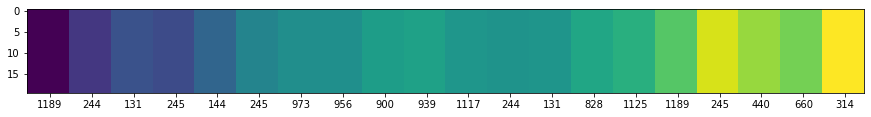

In [15]:
def visualize_attention_weights(w, seq_wordvec, indices):
	plt.figure(figsize=(15, 6))
	ax = plt.gca()

	seq_wordvec_indices = [seq_wordvec[i] for i in indices]
	w_indices = np.array([w[0,i] for i in indices])

	horizontal_rep = 10
	w_indices = np.repeat(w_indices, horizontal_rep, axis=0)
	w_indices = np.reshape(w_indices, (1, horizontal_rep*len(indices)))
	w_indices = np.repeat(w_indices, 20, axis=0)
	ax.imshow(w_indices)
	

	# ax.set_xticks(np.arange(len(indices)))
	ax.set_xticks(np.linspace(0, (len(indices)-1)*horizontal_rep, len(indices)) + horizontal_rep/2)
	ax.set_xticklabels(seq_wordvec_indices)
	plt.show()

visualize_attention_weights(w, convert_word_to_indexseq(seq), np.arange(20))

### Beam Search
In this part, I will implement **beam search**, which is a recursive and greedy algorithm that not only choose the next word prediction with the highest softmax score, but chooses the next k-length sequence with the highest score. In this work, I will choose `k=3` for simplification. The softmax score for the whole 3-word sequence is calculated as the logsum of the score of each word.

In [16]:
length_generated = 10 # generate 10 words after
def text_generation_beam_search_sentence(seq, model, beam_search_k, length_generated):
	# clean sentence
	seq = seq.lower()
	seq = re.sub(r'[^a-zA-Z0-9_\s]', ' ', seq)
	seq = seq.replace('\n', ' \n ')
	for w in word_to_remove: # delete word
		seq = seq.replace(' '+w+' ', ' ')
	seq_wordvec = seq.split(' ')
	seq_wordvec = [w for w in seq_wordvec if len(w)>0]
	seq_wordvec = [w for w in seq_wordvec if w in word_list]
	seq_wordvec = seq_wordvec[:100]
	pattern = convert_word_to_indexseq(seq_wordvec)
	print(' '.join(seq_wordvec))

	max_proba, last_word, generated_sequence = beam_search_recursion(pattern, 0, model, beam_search_k, length_generated)
	print(convert_index_to_wordseq(generated_sequence))

In [17]:
def beam_search_recursion(pattern, previous_proba, model, beam_search_k, length_generated):
	# print('Length: '+str(length_generated))
	if length_generated == 0: # no more words to generate
		return previous_proba, 0, [0]

	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(len(word_list))
	prediction = model.predict(x, verbose=0)
	sorted_index = np.argsort(-prediction) # sorted reverse
	beam_search_index = sorted_index[0,:beam_search_k]
	beam_search_proba = prediction[0, beam_search_index] # probabilities

	probas = []
	best_indices = []
	for k in range(beam_search_k):
		proba = previous_proba + np.log(beam_search_proba[k])
		proba_k, best_index, full_pattern = beam_search_recursion(pattern[1:] + [beam_search_index[k]], 
			proba, model, beam_search_k, length_generated-1)
		probas.append(proba_k)
		best_indices.append(best_index)
	max_proba = np.max(probas)
	full_pattern = [beam_search_index[np.argmax(probas)]] + full_pattern

	return max_proba, beam_search_index[np.argmax(probas)], full_pattern

In [18]:
text_generation_beam_search_sentence(sentence, model_attention, 3, 10) # length_generated = 10

few studies have examined the role of maternal status in diseases in offspring and findings have been we used a large cohort in to explore the association of the markers for maternal status maternal and intake during with development in offspring during early childhood we analyzed information on children age 0 3 years from the environment and children s study we used models and models to evaluate the effect of maternal and levels and intake on in children models were also with score matched data were collected for a total of child the prevalence 95 confidence interval of low and
['in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'differences', '0']


The generated text is exactly the same as non-beam search result from LSTM because each word has the same weight in the 100-word sequence. Each new word does not have as much weight as previous 99 words, so changing the last word does not affect the next generated word. It might be better to perform beam search with a large `k` and put more weight on the newer generated words compared to the previous ~97-word sequence.

Currently, for evaluation, I am using only visual assessment of the attention module. Another option is to use criteria such as BLEU (similarity to a sentence), but since our generated text is not very good the BLEU score is guaranteed to be low.

In [19]:
length_generated = 10
def text_generation_random_BLEU_score(model):
    start = np.random.randint(0, len(abstract_wordvec)-length_generated)
    sequence = abstract_wordvec[start:start+100*2]
    seq = ' '.join(sequence)

    seq = seq.lower()
    seq = re.sub(r'[^a-zA-Z0-9_\s]', ' ', seq)
    seq = seq.replace('\n', ' \n ')
    for w in word_to_remove: # delete word
        seq = seq.replace(' '+w+' ', ' ')
    seq_wordvec = seq.split(' ')
    seq_wordvec = [w for w in seq_wordvec if len(w)>0]
    seq_wordvec = [w for w in seq_wordvec if w in word_list]
    seq_wordvec_sentence = seq_wordvec[:100]
    seq_wordvec_truth = seq_wordvec[100:100+length_generated]
    pattern = convert_word_to_indexseq(seq_wordvec_sentence)
    truth = convert_word_to_indexseq(seq_wordvec_truth)
    seq = seq_wordvec_sentence

    generated = []
    print(' '.join(seq_wordvec))

    for i in range(length_generated):
        x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(len(word_list))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = convert_index_to_wordseq([index])
        seq += result
        pattern.append(index)
        pattern = pattern[1:len(pattern)]
        print(result[0])
        generated.append(result[0])
    BLEU_score = sentence_bleu(seq_wordvec_truth, ' '.join(generated))
    print(BLEU_score)

    return seq_wordvec_truth, generated, BLEU_score

In [20]:
results = text_generation_random_BLEU_score(model_attention)

biological trial was conducted on day old n  which were into 6 groups 8 with 5 six experimental were to diet i qpm diet ii kg diet iii kg diet iv qpm kg diet v and qpm kg diet the and intake were at supplementation of csm and with qpm or depressed p   0 05 ratio and variables in improvement of and breast was among the groups kg csm and kg with a qpm based diet compared with those groups kg csm and kg with or qpm the energy and protein utilization decreased among the groups csm and however protein and energy utilization was increased p   0 05 among the groups qpm based compared with those groups csm and with or qpm therefore it has been that the performance and other parameters did not differ between the groups and qpm based in the present experiment however qpm with csm and improved the performance parameters and nutrient utilization over csm and with are one of the most common that are by many including infection severe inflammatory response expression of and formation the aim of this

# Conclusion
For this work we created a LSTM network with self-attention module and a beam search algorithm to perform text generation for medical abstracts on PubMed. The results are not ideal, since the LSTM network is small (1 layer) and we don't have a lot of training data (only 300 short abstracts). If we have more training data and use a more complex network (maybe transformer BERT), then it is possible to perform better. Overall, the beam search and attention module can improve performance, but we will need a robust deep learning network as base in order to do well.